In [1]:
#导入库cell
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance_matrix, ConvexHull
import random
from random import choice
import os
from PIL import Image
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy.spatial.distance import pdist, squareform
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

# 修改plt默认图形大小
plt.rcParams['figure.figsize'] = [5, 5]
# 修改默认字体大小
plt.rcParams['font.size'] = 12
# 修改默认坐标轴标签的字体
plt.rcParams['axes.labelsize'] = 10

In [2]:
#定义函数cell
# 计算两点之间的距离
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# 计算两线段的角度
def calculate_angle(p1, p2):
    return math.degrees(math.atan2(p2[1] - p1[1], p2[0] - p1[0]))

# 计算点到线段的最短距离
def point_to_line_distance(point, line):
    p1, p2 = line
    line_vector = np.array(p2) - np.array(p1)
    point_vector = np.array(point) - np.array(p1)
    line_length = np.linalg.norm(line_vector)
    unit_line_vector = line_vector / line_length
    projected_point_length = np.dot(point_vector, unit_line_vector)
    if projected_point_length < 0:
        return calculate_distance(point, p1)
    elif projected_point_length > line_length:
        return calculate_distance(point, p2)
    else:
        projected_point = p1 + projected_point_length * unit_line_vector
        return calculate_distance(point, projected_point)
        
def angle_between(v1, v2):
    # 计算两个向量之间的角度
    return np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0)))
    
# 判断两线段的一致性
def check_consistency(line1, line2):
    # 判断角度差
    angle1 = calculate_angle(*line1)
    angle2 = calculate_angle(*line2)
    if abs(angle1 - angle2) > 5:
        return False

    # 判断线段1中点到线段2所在直线的垂直距离
    midpoint_line1 = [(line1[0][0]+line1[1][0])/2, (line1[0][1]+line1[1][1])/2]
    if point_to_line_distance(midpoint_line1, line2) > 10:
        return False

    # 判断以线段为直径的圆的关系
    c1 = [(line1[0][0]+line1[1][0])/2, (line1[0][1]+line1[1][1])/2]
    c2 = [(line2[0][0]+line2[1][0])/2, (line2[0][1]+line2[1][1])/2]
    r1 = calculate_distance(line1[0], line1[1]) / 2
    r2 = calculate_distance(line2[0], line2[1]) / 2
    d = calculate_distance(c1, c2)
    if d > max(r1, r2):
        return False

    return True
def find_matching_lines(lines1, lines2):
    lines3 = []
    for line1 in lines1:
        for line2 in lines2:
            if check_consistency(line1, line2):
                lines3.append(line1)
                break
    return lines3

def generate_web(points):
    # 计算所有点之间的距离
    distances = squareform(pdist(points))

    # 对每个点，找到最近的n个点，并生成线段
    lines = []
    for i in range(len(points)):
        nearest_indices = np.argsort(distances[i])[:20]  # 包括自己，所以取n+1个
        temp_lines = []
        for j in nearest_indices:
            if i != j:  # 排除自己
                line = np.array([points[i], points[j]])
                if np.linalg.norm(line[0] - line[1]) > 20:  # 线段长度必须大于9
                    temp_lines.append(line)

        # 对每个点生成的线段进行角度判断
        for k in range(len(temp_lines)):
            for l in range(k+1, len(temp_lines)):
                v1 = temp_lines[k][1] - temp_lines[k][0]
                v2 = temp_lines[l][1] - temp_lines[l][0]
                if angle_between(v1, v2) < 5:  # 如果两条线段角度小于五度
                    if np.linalg.norm(v1) < np.linalg.norm(v2):  # 保留较短的那条
                        temp_lines[l] = temp_lines[k]
                    else:
                        temp_lines[k] = temp_lines[l]
        lines.extend(temp_lines)
    return np.array(lines)
'''
有一个（n，2，2）的数组lines存储着线段信息，有一个（m，2）的数组corners存储点的信息，他们都在同一个xy坐标系中。我的任务是要画出corners的连线connects（x，2，2）。以lines中的线段数据作为辅助判断标准。
我的思路是这样的：先预设一个距离值r，对corners中的每条线段进行判断，每一条线有两个端点pt1、pt2，在corners中检查所有点到pt1、pt2的距离，分别找到距离pt1最近的点corner1，距离pt2最近的点corner2。如果pt1- corner1连线和pt2-corner2连线长度都小于r，则输出corner1- corner2的连线到connects（x，2，2）数组。最后给connects（x，2，2）数组去除重复项目。注意：（（1，1），（2，2））和（（2，2），（1，1））应当被视为重复项目。
帮我把上面的过程打包成一个函数find_matching_corners_connection(lines, corners,r)
'''
def find_matching_corners_connection(lines, corners, r):
    connects = []
    for line in lines:
        pt1, pt2 = line
        distances_to_pt1 = np.sqrt(np.sum((corners - pt1)**2, axis=1))
        distances_to_pt2 = np.sqrt(np.sum((corners - pt2)**2, axis=1))
        corner1 = corners[np.argmin(distances_to_pt1)]
        corner2 = corners[np.argmin(distances_to_pt2)]
        if np.linalg.norm(corner1 - pt1) < r and np.linalg.norm(corner2 - pt2) < r:
            connects.append(tuple(sorted([tuple(corner1), tuple(corner2)])))
    # remove duplicates
    connects = [list(item) for item in set(connects)]
    return np.array(connects)

In [3]:
#调参cell
#调整角点识别参数
def gfttp(paramter1, paramter2, paramter3, paramter4, paramter5, paramter6):
    print('角点识别')
    print(f'maxCorners要检测的最大角点数目。如果超过此数目，将返回最强的角点: {paramter1}')
    print(f'qualityLevel角点的质量水平阈值。范围是0到1之间，表示角点质量的最小阈值: {paramter2}')
    print(f'minDistance两个角点之间的最小欧几里德距离。如果两个角点的距离小于此值，则只有其中一个会被保留: {paramter3}')
    print(f'blockSize：角点检测时的窗口大小。这个参数影响角点检测的精度: {paramter4}')
    print(f'useHarrisDetector一个布尔值，如果为True，则使用Harris角点检测器，如果为False，则使用Shi-Tomasi角点检测器: {paramter5}')
    print(f'k：Harris角点检测器的自由参数k。它影响角点响应函数的灵敏度，一般是0.04，减小能使检测器更灵敏: {paramter6} ')
    return paramter1, paramter2, paramter3, paramter4, paramter5, paramter6
#调整线段识别参数
def hlpp(paramter1, paramter2, paramter3, paramter4, paramter5):
    print('线段识别')
    print(f'rho：极坐标中的距离精度，通常设置为1像素: {paramter1}')
    print(f'theta：极坐标中的角度精度，通常设置为π/180，表示1度: {paramter2}')
    print(f'threshold：阈值，用于确定一条直线所需的最小投票数。只有在投票数超过这个阈值时，直线才会被检测到: {paramter3}')
    print(f'blockSize：minLineLength：线段的最小长度。小于此长度的线段将被忽略: {paramter4}')
    print(f'maxLineGap：在两条线段之间认为是一条直线的最大距离。如果两条线段之间的距离小于此值，它们将被合并成一条直线: {paramter5}')
    return paramter1, paramter2, paramter3, paramter4, paramter5



interactive_plot = interactive(gfttp, paramter1=(0,500,1), 
                               paramter2=(0.000,0.100,0.001),
                               paramter3=(1,50,1), 
                               paramter4=(1,10,1),
                               paramter5=(0,1,1),
                               paramter6=(0.00,0.10,0.01))
interactive_plot.children[0].value = 500
interactive_plot.children[1].value = 0.01
interactive_plot.children[2].value = 16
interactive_plot.children[3].value = 5
interactive_plot.children[4].value = 0
interactive_plot.children[5].value = 0.02

interactive_hlpp = interactive(hlpp, paramter1=(0,10,1), 
                               paramter2=(0,0.3141592653589793,0.017453292519943295),
                               paramter3=(0,100,1), 
                               paramter4=(0,100,1),
                               paramter5=(0,100,1))
interactive_hlpp.children[0].value = 1
interactive_hlpp.children[1].value = 0.017453292519943295
interactive_hlpp.children[2].value = 15
interactive_hlpp.children[3].value = 15
interactive_hlpp.children[4].value = 15
display(interactive_plot)
display(interactive_hlpp)

interactive(children=(IntSlider(value=500, description='paramter1', max=500), FloatSlider(value=0.01, descript…

interactive(children=(IntSlider(value=1, description='paramter1', max=10), FloatSlider(value=0.017453292519943…

In [5]:
def pic_corners_connections_detect(pic_dir, depth_dir, save_dir, interactive_plot, interactive_hlpp):
    img = cv2.imread(pic_dir)
    cv2.imwrite(os.path.join(save_dir, 'source.png'),img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    p1,p2,p3,p4,p5,p6 = interactive_plot.result
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=p1, qualityLevel=p2, minDistance=p3, blockSize=int(p4), useHarrisDetector=p5, k=p6)
    corners = np.intp(corners)
    #canny可能还需要调参
    edges = cv2.Canny(gray, 40, 190, apertureSize=3)
    hlp1,hlp2,hlp3,hlp4,hlp5 = interactive_hlpp.result
    lines = cv2.HoughLinesP(edges, rho=hlp1, theta=hlp2, threshold=hlp3, minLineLength=hlp4, maxLineGap=hlp5)
    points1 = corners
    points1 = np.squeeze(points1)
    distances = distance_matrix(points1, points1)
    lines2 = lines
    lines2 = lines2.reshape(-1, 2)
    lines2 = lines2.reshape(-1, 2, 2)
    lines1 = generate_web(corners.reshape(-1,2))
    #导出角点网格图
    blank_image=cv2.imread(pic_dir)
    for line in lines1.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(blank_image, (x1, y1), (x2, y2), (0, 200, 100), 1)  
    cv2.imwrite(os.path.join(save_dir, 'corner_web.png'),blank_image)
    plt.imshow(blank_image)
    plt.show()
    #导出角点网格图
    blank_image1=cv2.imread(pic_dir)
    for line in lines2.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(blank_image1, (x1, y1), (x2, y2), (0, 200, 200), 1)  
    cv2.imwrite(os.path.join(save_dir, 'line_web.png'),blank_image1) 
    plt.imshow(blank_image1)
    plt.show()
    #用识别网格辅助筛选角点网格
    lines3 = find_matching_lines(lines1, lines2)
    lines4 = find_matching_corners_connection(lines2, corners.reshape(-1,2), 5)
    lines3 = np.array(lines3)
    #导出筛选后的网格图
    blank_image2=cv2.imread(pic_dir)
    for line in lines3.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(blank_image2, (x1, y1), (x2, y2), (100, 200, 100), 1)  
    cv2.imwrite(os.path.join(save_dir, 'correct_web.png'),blank_image2)
    plt.imshow(blank_image2)
    plt.show()
    #导出筛选后的网格图2
    blank_image4=cv2.imread(pic_dir)
    for line in lines4.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(blank_image4, (x1, y1), (x2, y2), (100, 200, 100), 1)  
    cv2.imwrite(os.path.join(save_dir, 'correct_web_2.png'),blank_image4)
    plt.imshow(blank_image4)
    plt.show()    
    #用凸包算法找到网格边界
    hull = ConvexHull(corners.reshape(-1,2))
    points = corners.reshape(-1,2)
    edges = []
    for simplex in hull.simplices:
        edge = points[simplex]
        edges.append(edge)
    edges = np.array(edges)
    corners = np.array(corners)
    corners = corners.reshape(-1,2)
    depth_img = cv2.imread(depth_dir, cv2.IMREAD_GRAYSCALE)
    if depth_img is None:
        print('无法读取图片')
        print(depth_dir)
        sys.exit()
    depth_values = depth_img[corners[:, 1], corners[:, 0]]
    points_depth = np.column_stack((corners, depth_values))
    points_depth = np.array(points_depth)
    np.savetxt(os.path.join(save_dir, 'points_depth.txt'), points_depth, fmt='%d', delimiter=', ')
    lines3 = lines3.reshape(-1, 2, 2)
    depth_values_start = depth_img[lines3[:, 0, 1], lines3[:, 0, 0]]
    depth_values_end = depth_img[lines3[:, 1, 1], lines3[:, 1, 0]]
    lines_depth_start = np.column_stack((lines3[:, 0, :], depth_values_start))
    lines_depth_end = np.column_stack((lines3[:, 1, :], depth_values_end))
    lines_depth = np.stack((lines_depth_start, lines_depth_end), axis=1)
    with open(os.path.join(save_dir, 'lines_depth.txt'), 'w') as f:
        for line in lines_depth:
            f.write(','.join(map(str, line[0])) + ' ' + ','.join(map(str, line[1])) + '\n')
    depth_values_edges_start = depth_img[edges[:, 0, 1], edges[:, 0, 0]]
    depth_values_edges_end = depth_img[edges[:, 1, 1], edges[:, 1, 0]]
    edges_depth_start = np.column_stack((edges[:, 0, :], depth_values_edges_start))
    edges_depth_end = np.column_stack((edges[:, 1, :], depth_values_edges_end))
    edges_depth = np.stack((edges_depth_start, edges_depth_end), axis=1)
    with open(os.path.join(save_dir, 'edges_depth.txt'), 'w') as f:
        for edge in edges_depth:
            f.write(','.join(map(str, edge[0])) + ' ' + ','.join(map(str, edge[1])) + '\n')
    cv2.imwrite(os.path.join(save_dir, 'depth.png'),depth_img)
    blank_image3 = cv2.imread(pic_dir)
    for line in edges.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(blank_image3, (x1, y1), (x2, y2), (0, 0, 255), 1)   
    for corner in corners.reshape(-1,2):
        x, y = corner
        cv2.circle(blank_image3, (x, y), 4, 255, -1)  # 在角点位置绘制圆
    cv2.imwrite(os.path.join(save_dir, 'edges_points.png'),blank_image3)
    for line in lines3.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(blank_image3, (x1, y1), (x2, y2), (100, 200, 100), 1)  
    cv2.imwrite(os.path.join(save_dir, 'edges_points_webs.png'),blank_image3)
    plt.imshow(blank_image3)
    plt.show()
    print('检测到角点数目',len(corners),' 角点连线数目',len(lines1),' 检测连线数目',len(lines2),' 最终连线数目',len(lines3))


def dir_corners_connections_detect(pics_dir, depths_dir, saves_dir, interactive_plot, interactive_hlpp):
    pics = os.listdir(pics_dir)
    for pic in pics:
        pic_name = os.path.splitext(pic)[0]
        pic_dir = os.path.join(pics_dir, pic)
        depth_dir = os.path.join(depths_dir, pic_name + '_depth'+'.png')
        save_dir = os.path.join(saves_dir, pic_name)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        pic_corners_connections_detect(pic_dir, depth_dir, save_dir, interactive_plot, interactive_hlpp)


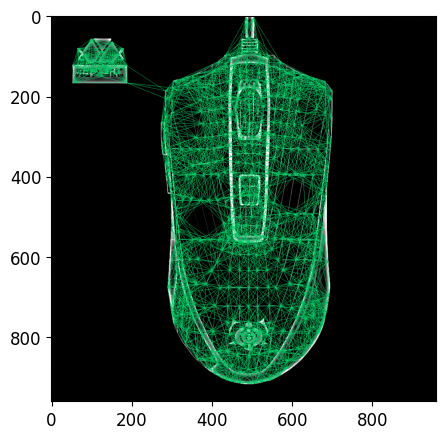

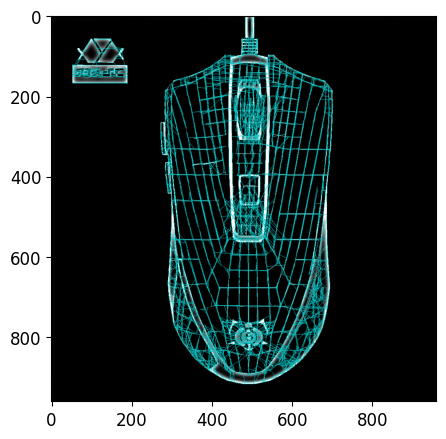

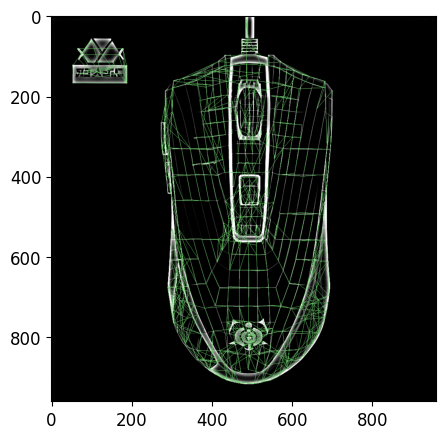

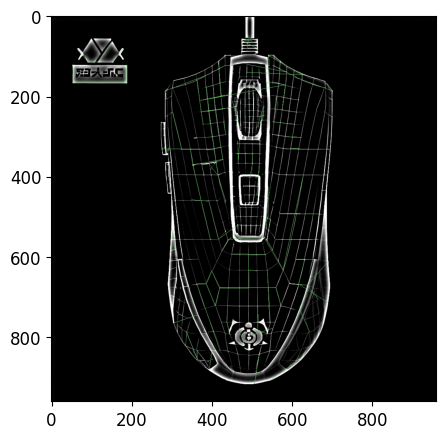

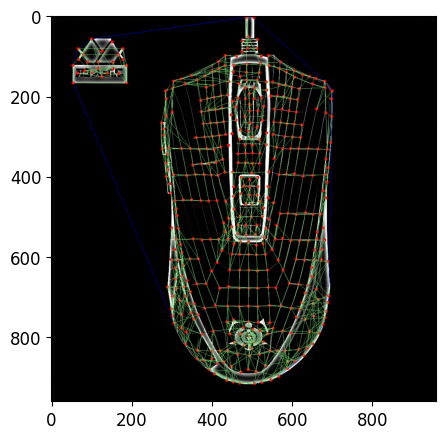

检测到角点数目 438  角点连线数目 7868  检测连线数目 1686  最终连线数目 1368
CPU times: total: 20.7 s
Wall time: 46.5 s


In [53]:
%%time
dir_corners_connections_detect('928\\test\\ln', '928\\test\\dp', '928\\test\\sv', interactive_plot, interactive_hlpp)

image_read
检测到角点数目 480


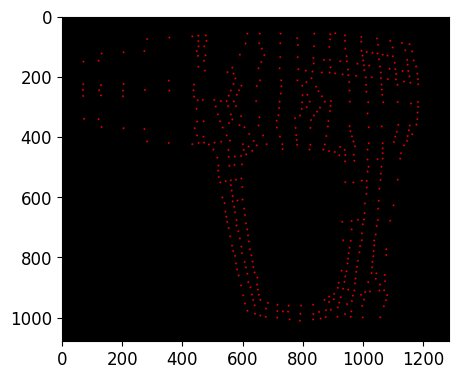

检测到连线数目 931


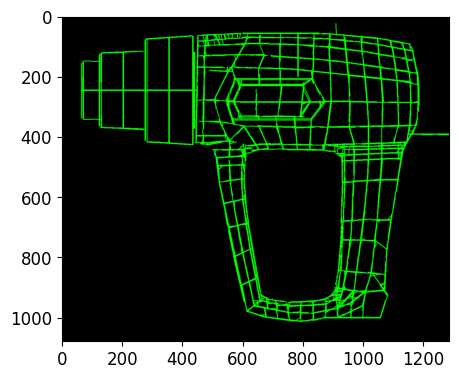

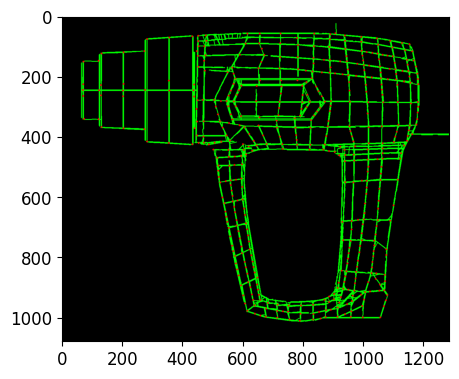

In [6]:
#角点识别与线段识别cell
img = cv2.imread('in03f.jpg')# 读取图像
if img is None:
    print("no_image")
    sys.exit()# 如果读取错误，则退出
else:
    print("image_read")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# 转为灰度图像才能做角点检测
# 角点检测
p1,p2,p3,p4,p5,p6=interactive_plot.result
corners = cv2.goodFeaturesToTrack(gray, maxCorners=p1, qualityLevel=p2, minDistance=p3, blockSize=int(p4), useHarrisDetector=p5, k=p6)
corners = np.intp(corners)  # 转换为整数坐标
print('检测到角点数目',len(corners))
height, width, _ = img.shape
blank_image = np.zeros((height, width, 3), dtype=np.uint8)
for corner in corners:
    x, y = corner.ravel()  # 将角点坐标展平
    cv2.circle(blank_image, (x, y), 3, 255, -1)  # 在角点位置绘制圆
plt.imshow(blank_image)
plt.show()
edges = cv2.Canny(gray, 40, 190, apertureSize=3)
# 使用Hough变换检测直线
hlp1,hlp2,hlp3,hlp4,hlp5=interactive_hlpp.result
lines = cv2.HoughLinesP(edges, rho=hlp1, theta=hlp2, threshold=hlp3, minLineLength=hlp4, maxLineGap=hlp5)
if lines is None:
    print("该参数检测不到线段")
    sys.exit()
else:
    print("检测到连线数目 "+str(len(lines)))  
height, width, _ = img.shape
blank_image = np.zeros((height, width, 3), dtype=np.uint8)   
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(blank_image)
plt.show()
for corner in corners:
    x, y = corner.ravel()  # 将角点坐标展平
    cv2.circle(blank_image, (x, y), 3, 255, -1)  # 在角点位置绘制圆
plt.imshow(blank_image)
plt.show()


(8722, 2, 2)
(931, 2, 2)
(1249, 2, 2) 1249
(1249, 4) 1249


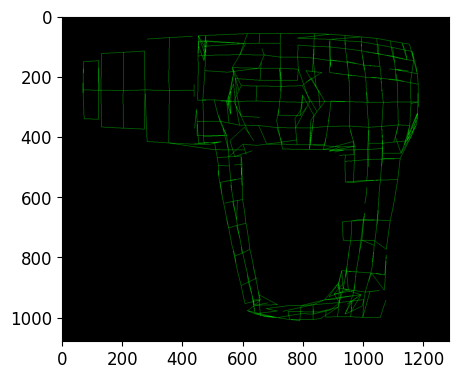

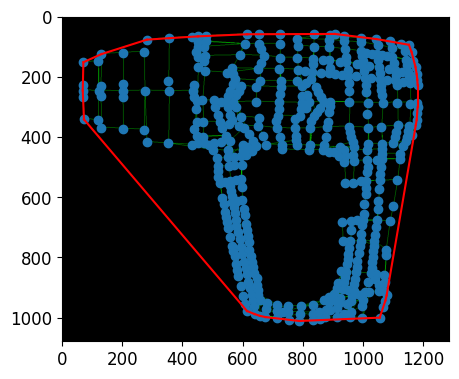

In [7]:
# 以角点作为基础，以线作为辅助判断标准
points1=corners
points1 = np.squeeze(points1)
# 计算所有点之间的距离
distances = distance_matrix(points1, points1)
#lines2 = np.random.rand(500, 2, 2)  # 500条线段的端点
lines2=lines
lines2=lines2.reshape(-1, 2)
lines2=lines2.reshape(-1, 2, 2)


# 对每个点，找到最近的n个点，并生成线段
'''

for i in range(len(points1)):
    nearest_indices = np.argsort(distances[i])[:15]  # 包括自己，所以取n+1个
    for j in nearest_indices:
        if i != j:  # 排除自己
            lines1.append(np.array([points1[i], points1[j]]))
lines1=np.array(lines1)
'''
lines1 = generate_web(corners.reshape(-1,2))
print(lines1.shape)
print(lines2.shape)
lines3=find_matching_lines(lines1, lines2)
lines3 = np.array(lines3)
print(lines3.shape,len(lines3))
height, width, _ = img.shape
blank_image = np.zeros((height, width, 3), dtype=np.uint8)
lines3=lines3.reshape(-1, 4)
print(lines3.shape,len(lines3))
height, width, _ = img.shape
blank_image = np.zeros((height, width, 3), dtype=np.uint8)
for line in lines3:
    x1, y1, x2, y2 = line
    cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
plt.imshow(blank_image)
plt.show()
# 计算凸包
hull = ConvexHull(corners.reshape(-1,2))
points=corners.reshape(-1,2)
# 存储凸包的边
edges = []
for simplex in hull.simplices:
    edge = points[simplex]
    edges.append(edge)
edges = np.array(edges)
plt.imshow(blank_image)
plt.scatter(points[:,0], points[:,1])
for edge in edges:
    plt.plot(edge[:, 0], edge[:, 1], 'r')

plt.show()

In [22]:
#文件存储cell
# 将corners转换为字符串，每个元素占一行，x和y坐标由逗号分隔
corners_str = '\n'.join([','.join(map(str, corner[0])) for corner in corners])
# 打开一个文件，如果不存在则创建
file = open("corners926.txt", "w")
# 写入数据
file.write(corners_str)
# 关闭文件
file.close()
# 将数组转换为字符串，每行有两个坐标，坐标内部的x和y由逗号分隔，两个坐标之间由空格分隔
lines_str = '\n'.join(['{},{} {},{}'.format(line[0], line[1], line[2], line[3]) for line in lines3])
# 打开一个文件，如果不存在则创建
file = open("lines926.txt", "w")
# 写入数据
file.write(lines_str)
# 关闭文件
file.close()

In [40]:
#深度检测与输出cell
corners=np.array(corners)
corners=corners.reshape(-1,2)
depth_img = cv2.imread('depth927.png', cv2.IMREAD_GRAYSCALE)  # 读取深度图像
# 首先，我们需要将点的坐标转换为整数，因为像素的索引必须是整数
corners=corners.astype(int)
depth_values = depth_img[corners[:, 1], corners[:, 0]]
points_depth = np.column_stack((corners, depth_values))
points_depth=np.array(points_depth)
np.savetxt('points_depth.txt', points_depth, fmt='%d', delimiter=', ')
lines3=lines3.reshape(-1, 2, 2)
depth_values_start = depth_img[lines3[:, 0, 1], lines3[:, 0, 0]]
depth_values_end = depth_img[lines3[:, 1, 1], lines3[:, 1, 0]]
lines_depth_start = np.column_stack((lines3[:, 0, :], depth_values_start))
lines_depth_end = np.column_stack((lines3[:, 1, :], depth_values_end))
lines_depth = np.stack((lines_depth_start, lines_depth_end), axis=1)
with open('lines_depth.txt', 'w') as f:
    for line in lines_depth:
        # 将每一行的两个三元组转化为字符串，然后写入文件
        f.write(','.join(map(str, line[0])) + ' ' + ','.join(map(str, line[1])) + '\n')

array([[361, 241, 244],
       [ 49, 356, 157],
       [351, 443, 232],
       ...,
       [480, 452, 102],
       [515, 441, 205],
       [472, 774, 181]])

In [ ]:
img = cv2.imread(pic_dir)# 读取图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# 转为灰度图像才能做角点检测
# 角点检测
p1,p2,p3,p4,p5,p6=interactive_plot.result
corners = cv2.goodFeaturesToTrack(gray, maxCorners=p1, qualityLevel=p2, minDistance=p3, blockSize=int(p4), useHarrisDetector=p5, k=p6)
corners = np.intp(corners)  # 转换为整数坐标
edges = cv2.Canny(gray, 40, 190, apertureSize=3)
hlp1,hlp2,hlp3,hlp4,hlp5=interactive_hlpp.result
lines = cv2.HoughLinesP(edges, rho=hlp1, theta=hlp2, threshold=hlp3, minLineLength=hlp4, maxLineGap=hlp5)
# 以角点corners作为基础，以lines线作为辅助判断标准,建立cornners之间的连线并判定
points1=corners
points1 = np.squeeze(points1)
# 计算所有点之间的距离
distances = distance_matrix(points1, points1)
#lines2 = np.random.rand(500, 2, 2)  # 500条线段的端点
lines2=lines
lines2=lines2.reshape(-1, 2)
lines2=lines2.reshape(-1, 2, 2)
lines1 = generate_web(corners.reshape(-1,2))
lines3=find_matching_lines(lines1, lines2)
lines3 = np.array(lines3)
# 计算凸包
hull = ConvexHull(corners.reshape(-1,2))
points=corners.reshape(-1,2)
# 存储凸包的边
edges = []
for simplex in hull.simplices:
    edge = points[simplex]
    edges.append(edge)
edges = np.array(edges)
#深度检测与输出cell
corners=np.array(corners)
corners=corners.reshape(-1,2)
depth_img = cv2.imread(depth_dir, cv2.IMREAD_GRAYSCALE)  # 读取深度图像
depth_values = depth_img[corners[:, 1], corners[:, 0]]
points_depth = np.column_stack((corners, depth_values))
points_depth=np.array(points_depth)
np.savetxt('points_depth.txt', points_depth, fmt='%d', delimiter=', ')
lines3=lines3.reshape(-1, 2, 2)
depth_values_start = depth_img[lines3[:, 0, 1], lines3[:, 0, 0]]
depth_values_end = depth_img[lines3[:, 1, 1], lines3[:, 1, 0]]
lines_depth_start = np.column_stack((lines3[:, 0, :], depth_values_start))
lines_depth_end = np.column_stack((lines3[:, 1, :], depth_values_end))
lines_depth = np.stack((lines_depth_start, lines_depth_end), axis=1)
with open('lines_depth.txt', 'w') as f:
    for line in lines_depth:
        # 将每一行的两个三元组转化为字符串，然后写入文件
        f.write(','.join(map(str, line[0])) + ' ' + ','.join(map(str, line[1])) + '\n')

帮我写python代码，把上面的代码打包成两个函数
1,pic_corners_connections_detect(pic_dir,depth_dir,save_dir,interactive_plot,interactive_hlpp)其中pic_dir一张图片的路径,depth_dir是这张图片对应深度图的路径，save_dir是最终存储文件的路径。interactive_plot,interactive_hlpp是前文已经定义的两个值。在我写出的代码中定义了一个值edges，要帮我把edges也做生成lines_depth的类似操作，把edges转化成edges_depth.最后把生成的points_depth.txt，lines_depth.txt，以及额外生成的edges_depth.txt都保存在save_dir。这个函数不需要输出值。
2，dir_corners_connections_detect(pics_dir,depths_dir,saves_dir,interactive_plot,interactive_hlpp)其中pics_dir是一个存储图片的文件夹，depths_dir是一个存储深度图的文件夹，每张图片都有一张深度图与之对应，他们分辨率一致，深度图的名字是源文件的名字(不包含.png)后面加上_depth.saves_dir是用来存储输出结果的文件夹，每一张图片得到的三个txt文件（points_depth.txt，lines_depth.txt，edges_depth.txt）都要以子文件夹的形式存储在saves_dir中，子文件夹名字就是图片名字去除.pnginteractive_plot,interactive_hlpp是前文已经得到的两个值